In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')
from collections import Counter
import csv

import nltk
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud


In [2]:
domains = [ 'bc', 'bn', 'mz', 'nw', 'tc', 'wb' ]

model_types = [ 'baseline', 'pooling', 'mult' ]


# Results

## Exper I - Domain Adaptation

In [20]:
# plot_domain_f1_score(version=1)

get_domain_f1_score(version=1)


,bc,bn,mz,nw,tc,wb
baseline,66.3760,80.4868,72.6998,82.3054,38.4615,46.5294
pooling,79.6315,75.7305,60.9635,60.8837,59.1065,46.7852
mult,78.3231,81.8539,72.0238,76.3610,67.5410,50.2048


In [22]:
# plot_domain_f1_score(version=2)

get_domain_f1_score(version=2)


Error, model=>baseline, subset=>bc
Error, model=>baseline, subset=>bn
Error, model=>baseline, subset=>mz
Error, model=>baseline, subset=>nw
Error, model=>baseline, subset=>tc
Error, model=>baseline, subset=>wb


,bc,bn,mz,nw,tc,wb
baseline,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
pooling,78.4664,76.8552,60.9917,59.7088,64.6341,49.4614
mult,81.3725,78.6571,70.8364,78.5651,66.6667,53.9062


## Exper II - Sent len

,"[2,3)","[3,6)","[6,10)","[10,20)","[20,30)","[30,60)","[60,100)",mean,std
nw,85.7143,73.3333,85.0575,75.8003,74.2459,70.8632,73.1554,76.881414,5.55073
tc,0.0000,71.4286,67.8571,66.1417,54.5455,70.5882,80.0000,68.426850,7.59230


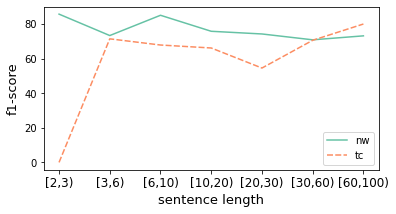

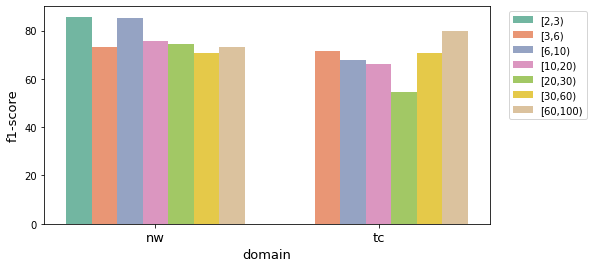

In [128]:
seq_len_range = '2,3,6,10,20,30,60,100'.split(',')

plot_seq_len_f1_score(seq_len_range, ['nw', 'tc'])
get_seq_len_f1_score(seq_len_range, [ 'nw', 'tc' ], mean=True)

# plot_seq_len_f1_score(seq_len_range, domains)
# get_seq_len_f1_score(seq_len_range, domains, mean=True)


[4, 80, 89, 573, 603, 706, 98]


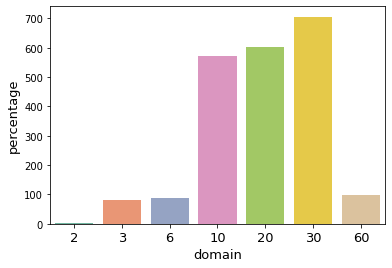

In [122]:
def test_counts_sent_len():
    sent_len = cal_sent_len('nw', ['test'])
    sent_len = np.array( sent_len.tolist() )

    count_range = []
    for i,v in enumerate(seq_len_range[:-1]):
        next_v = seq_len_range[i+1]
        count_range.append( len(sent_len[ (sent_len >= int(v)) & (sent_len < int(next_v)) ]) )

    print(count_range)

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x=seq_len_range[:-1], y=count_range, ax=ax)
    ax.set_xlabel('domain', fontsize=13)
    ax.set_ylabel('percentage', fontsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    plt.show()
test_counts_sent_len()

## Exper II - Rare Word

,"[1,2)","[2,3)","[3,4)","[4,5)","[5,6)","[6,9)","[9,26)","[26,999)",mean,std
nw,72.5424,72.0339,78.7770,68.5393,71.4286,75.4098,81.8414,79.7136,75.035750,4.370059
tc,68.9655,53.3333,43.4783,52.1739,80.0000,72.2222,69.8795,70.2703,63.790375,11.707742


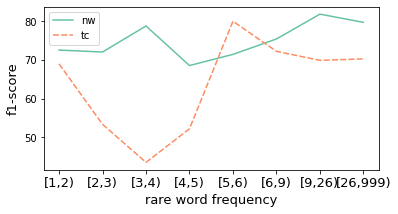

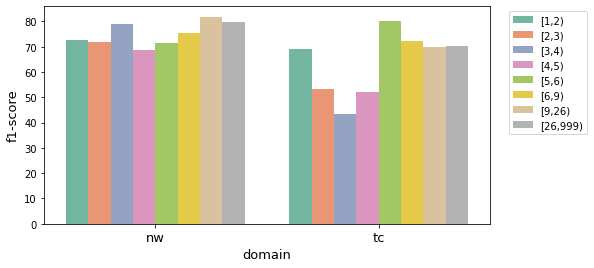

In [48]:
rare_freq_range = '1,2,3,4,5,6,9,26,999'.split(',')

plot_rare_f1_score(rare_freq_range, [ 'nw', 'tc'])
get_rare_f1_score(rare_freq_range, [ 'nw', 'tc'], mean=True)

# plot_seq_len_f1_score(rare_freq_range, domains)
# get_seq_len_f1_score(rare_freq_range, domains, mean=True)


## Exper II - POS

,"[0,2)","[2,4)","[4,6)","[6,10)","[10,999)",mean,std
nw,76.5847,76.3052,76.3433,74.0051,70.3297,74.7136,2.383723
tc,65.3595,79.1209,35.2941,60.0000,80.0000,63.9549,16.288084


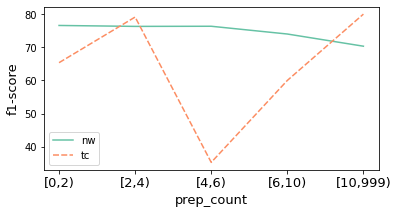

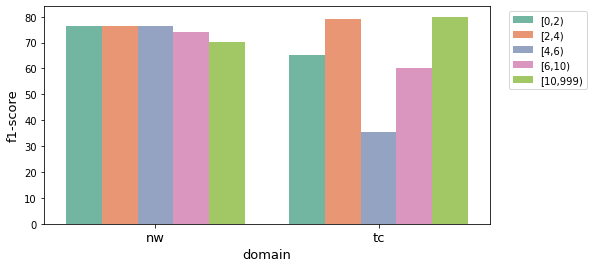

In [120]:
prep_range = '0,2,4,6,10,999'.split(',')

plot_prep_f1_score(prep_range, [ 'nw', 'tc'])
get_prep_f1_score(prep_range, [ 'nw', 'tc'], mean=True)

# plot_prep_score(prep_range, domains)
# get_prep_score(prep_range, domains, mean=True)


#  Domain Analysis - Sent Len

In [153]:
# in_domain_split_type = ['train', 'valid', 'test']
in_domain_split_type = ['train']

sents_per_domain = []
sent_len_per_domain = []
for d in domains:
    sents = load_sentences(d, in_domain_split_type)
    sents_per_domain.append( sents )
    sent_len_per_domain.append([ len( sent.split() ) for sent in sents['sentence'] ])


median_sent_len_per_domain = [ np.median( s ) for s in sent_len_per_domain ]
min_sent_len_per_domain = [ np.min( s ) for s in sent_len_per_domain ]
max_sent_len_per_domain = [ np.max( s ) for s in sent_len_per_domain ]


In [152]:
pd.Series(sent_len_per_domain[5]).describe()


count    16589.000000
mean        23.282778
std         14.624243
min          2.000000
25%         13.000000
50%         20.000000
75%         30.000000
max        220.000000
dtype: float64

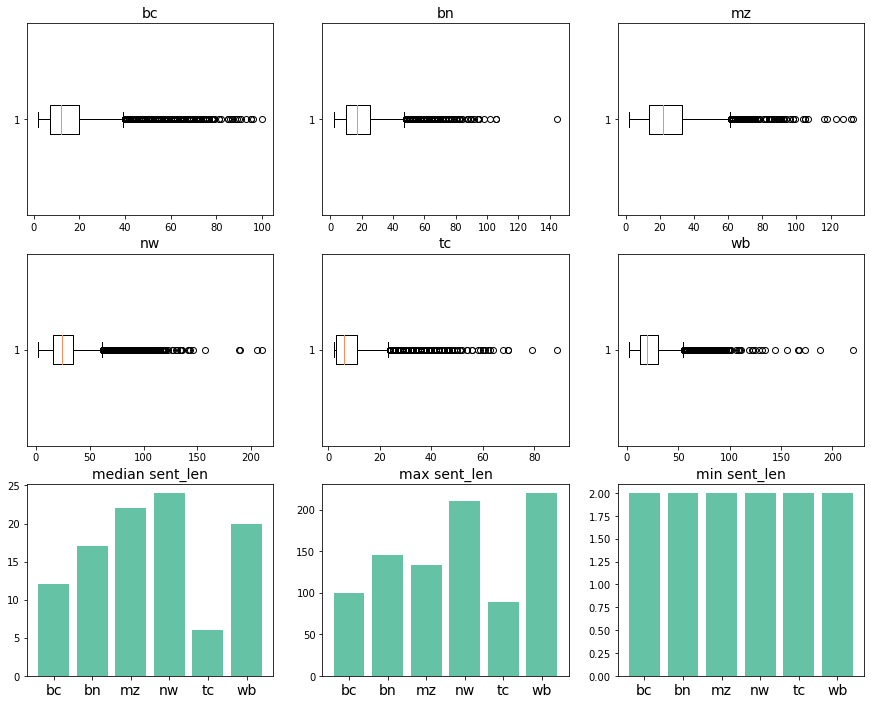

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))

for i, d in enumerate(domains):
    ax[i//3,i%3].boxplot(x=sent_len_per_domain[i], vert=False)
    ax[i//3,i%3].set_title(d, fontsize=14)


ax[2, 0].bar(x=domains, height=median_sent_len_per_domain)
ax[2, 0].set_title('median sent_len', fontsize=14)
# ax[2,0].set_xlabel('domain', fontsize=14)
# ax[2,0].set_ylabel('avg sent_len', fontsize=14)
ax[2, 0].xaxis.set_tick_params(labelsize=14)

ax[2,1].bar(x=domains, height=max_sent_len_per_domain)
ax[2,1].set_title('max sent_len', fontsize=14)
# ax[2,1].set_xlabel('domain', fontsize=14)
# ax[2,1].set_ylabel('max sent_len', fontsize=14)
ax[2,1].xaxis.set_tick_params(labelsize=14)


ax[2,2].bar(x=domains, height=min_sent_len_per_domain)
ax[2,2].set_title('min sent_len', fontsize=14)
# ax[2,2].set_xlabel('domain', fontsize=14)
# ax[2,2].set_ylabel('min sent_len', fontsize=14)
ax[2,2].xaxis.set_tick_params(labelsize=14)


plt.show()

## Upper IQR Seq Len

In [8]:
seq_len_upper_IQR_per_domain = []
for v in sent_len_per_domain:
    q75, q25 = np.percentile(v, [75 ,25])
    upper_iqr = 1.5 * (q75 - q25) + q75
    seq_len_upper_IQR_per_domain.append(upper_iqr)

seq_len_upper_IQR_per_domain

[39.5, 47.5, 61.5, 61.0, 23.0, 55.5]

[518, 350, 161, 1069, 595, 571]


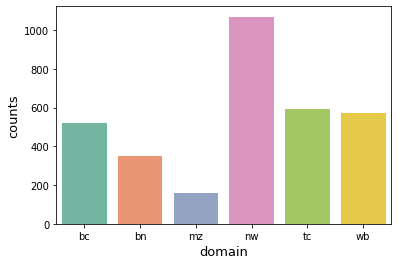

In [9]:
counts_above_per_domain = [ sum(np.array(sent_len_per_domain[i]) >= seq_len_upper_IQR_per_domain[i]) for i, d in enumerate(domains) ]
print(counts_above_per_domain)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=domains, y=counts_above_per_domain, ax=ax)
ax.set_xlabel('domain', fontsize=13)
ax.set_ylabel('counts', fontsize=13)
plt.show()


## Total Median Seq Len

In [10]:

total_seq_len = []
for l in sent_len_per_domain:
    total_seq_len += l

np.median( total_seq_len )


18.0

[0.7166976194496032, 0.5456511518570757, 0.38876093965914327, 0.3177233872455569, 0.9146579227224388, 0.4368557477846766]


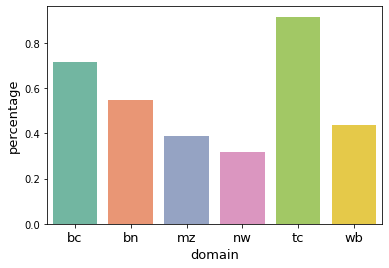

In [11]:
counts_below_per_domain = [ (sum(np.array(sent_len_per_domain[i]) <= np.mean( np.median( total_seq_len ) ) )) / len(sent_len_per_domain[i]) 
                           for i, d in enumerate(domains) ]
print(counts_below_per_domain)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=domains, y=counts_below_per_domain, ax=ax)
ax.set_xlabel('domain', fontsize=13)
ax.set_ylabel('percentage', fontsize=13)
ax.xaxis.set_tick_params(labelsize=13)
plt.show()


## Total Corpus

In [12]:
sent_len_all_domain = cal_sent_len('pool', ['train'])


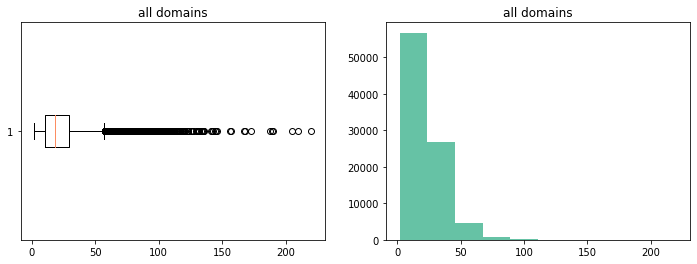

count    89389.000000
mean        21.196143
std         14.938677
min          2.000000
25%         10.000000
50%         18.000000
75%         29.000000
max        220.000000
dtype: float64

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].boxplot(x=sent_len_all_domain, vert=False)
ax[0].set_title('all domains')

# ax[1].hist(x=sent_len_all_domain[ sent_len_all_domain > 100])
ax[1].hist(x=sent_len_all_domain)
ax[1].set_title('all domains')
plt.show()

sent_len_all_domain.describe()


# Domain Analysis - Rare Word

## Word Freq of the vocabulary

sents with different scarcity of rare words (e.g. contains word <1% occurance freq)


In [6]:
sents_all_domain = load_sentences('tc', ['train'])
word_counts, words, freqs = cal_word_freq(sents_all_domain['sentence'].tolist())

pd.Series(freqs).describe()


count    5432.000000
mean       17.646539
std       140.520539
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      5197.000000
dtype: float64

40 1
50 2
60 2
65 3
70 3
75 4
80 5
90 13


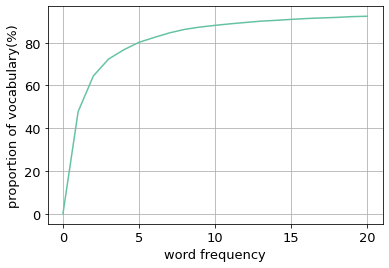

In [8]:
def plot_rare_freq(freqs, max_freq=20):
    rare_range = np.arange(0, max_freq + 1)
    cum_counts = []

    for i in rare_range:
        cum_word_count = sum(freqs <= i) / len(freqs) * 100
        cum_counts.append(cum_word_count)

    fig, ax = plt.subplots()
    sns.lineplot(x=rare_range, y=cum_counts, ax=ax)
    ax.set_xlabel('word frequency', fontsize=13)
    ax.set_ylabel('proportion of vocabulary(%)', fontsize=13)
    ax.grid()
    ax.xaxis.set_tick_params(labelsize=13)
    ax.yaxis.set_tick_params(labelsize=13)

    for v in [40,50,60,65,70,75,80,90]:
        print(v, rare_range[ np.array(cum_counts) >= v ][0])
    

plot_rare_freq(freqs, max_freq=20)


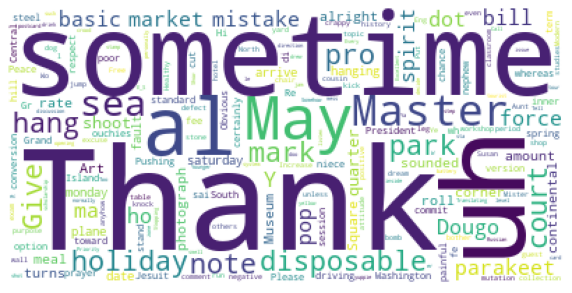

In [9]:

plot_word_cloud(' '.join( words[ 
    (freqs < 6) & (freqs >= 1)
]), size=(10, 10))



# Domain Analysis - POS

In [117]:
verb_list = 'VB-VBD-VBG-VBN-VBP-VBZ'
def load_pos_domain(domain='tc', sub_type='train', pos_list=[verb_list, 'IN']):
    '''
    https://huggingface.co/flair/pos-english
    VB	Verb, base form
    VBD	Verb, past tense
    VBG	Verb, gerund or present participle
    VBN	Verb, past participle
    VBP	Verb, non-3rd person singular present
    VBZ	Verb, 3rd person singular present
    '''
    pos_counts_by_sent = dict()
    for v in pos_list:
        pos_counts_by_sent[v] = set()


    with open('./data/' + domain + '/' + sub_type + '/dataset.csv', encoding='utf8') as f:
        csvreader = csv.reader(f, delimiter=',')

        pos_in_corpus = []
        for index, row in enumerate(csvreader):
            sentence_flag, word, pos, chunk_tag = row
            if len(sentence_flag) > 0: # start from a new sentence   
                pos_in_sent = []  
                pos_in_corpus.append( pos_in_sent )
            pos_in_sent.append( pos )

        for v in pos_in_corpus: # each sent
            pos_counter = Counter()
            pos_counter.update(v)
            for p in pos_list:
                total_counts = 0
                for sp in p.split('-'):
                    total_counts += pos_counter[sp]
                pos_counts_by_sent[p].add( total_counts )
       
    return pos_counts_by_sent



In [119]:
load_pos_domain('tc')

{'VB-VBD-VBG-VBN-VBP-VBZ': {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  17,
  19},
 'IN': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14}}

# Tools

In [17]:
def read_score(model='baseline', subset='bc', metric='micro_f1', subtype='test', version=0):
    '''
    model: baseline, pooling, mult
    subset: which sub dataset to be evaluated
    '''
       
    metric = subtype + '_' + metric
    metric_score = {} 
    metric_score[metric] = 0
    
    if 'pooling_' in model:
        model = 'pool_' + model.split('_')[-1]
    if model == 'mult':
        model = 'mult_private'
  
    if version > 0:
        version = '_' + str(version)
    else:
        version = ''

    fpath = './experiments' + version + '/' + model + '/' + subset + '/eval_' + subtype + '_best_metric.txt'

    try:
        with open(fpath, 'r', encoding='utf8') as f:
            for line in f:
                key, val = line.split(':')
                metric_score[key.strip()] = float(val.strip())
    except:
        print('Error, model=>{}, subset=>{}'.format(model, subset))

    if metric:
        return metric_score[metric]
    else:
        return metric_score

    
    
def load_sentences(domain='pool', data_type=['train', 'test', 'valid']):
    sents = None

    for dt in ['train', 'test', 'valid']:
        if dt not in data_type:
            continue
        
        dt_sents = pd.read_csv('./data/' + domain + '/' + dt + '/sentences.txt', sep='\n', header=None)
        if sents is None:
            sents = dt_sents
        else:
            sents = pd.concat([sents, dt_sents], axis=0)

    sents.columns = ['sentence']
    return sents



def cal_sent_len(domain='pool', sub_dataset=['train', 'valid', 'test']):
    sents = load_sentences(domain, sub_dataset)
    
    sent_len_all_domain = pd.Series([ len( sent.split() ) for sent in sents['sentence'] ])
    
    return sent_len_all_domain



def cal_word_freq(corpus):
    words = []
    for sent in corpus: # each sent
        for w in sent.split(): # each word            
            words.append(w)

    w_freq = nltk.FreqDist(words)

    return {w: q for w, q in w_freq.items()}, np.array(list(w_freq.keys())), np.array(list(w_freq.values()))



def plot_word_cloud(text, size=(8, 8)):
    wordcloud = WordCloud(
        background_color = 'white',
        random_state = 42
    ).generate(text)

    plt.figure( figsize=size )
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

    

def plot_counts_by_seq_len(sent_len_all_domain, sen_len_threshold, domain='all domains'):
    x_label = []
    sen_len_counts_by_threshold = np.zeros(len(sen_len_threshold) - 1)
        
    for i, v in enumerate(sen_len_threshold[:-1]):
        next_v = int(sen_len_threshold[ i + 1 ])
        v = int(v)
        range_sent_len = sent_len_all_domain[ 
            (sent_len_all_domain < next_v) & (sent_len_all_domain >= v)
        ]
        x_label.append('[{}, {})'.format(v, next_v))
        sen_len_counts_by_threshold[i] = len(range_sent_len) / len(sent_len_all_domain)

    print('counts', sen_len_counts_by_threshold)

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x=x_label, y=sen_len_counts_by_threshold)
    ax.set_ylabel('Counts', fontsize=13)
    ax.set_xlabel('Threshold of sent_len {}'.format(domain), fontsize=13)
    plt.show()

    

# Exper II - sent_len
def get_seq_len_f1_score(seq_len_range, domains, model='mult', mean=False, version=0):
    seq_len_f1 = []

    for d in domains: # each domain
        metric_per_model = []
        for t in seq_len_range[:-1]:
            metric_per_model.append( read_score(model=model, subset=d, subtype='test_sent_' + str(t), version=version) )
        
        if mean:
            metric_per_model_new = np.array(metric_per_model)
            metric_per_model.append(np.mean( metric_per_model_new[metric_per_model_new>0] ))
            metric_per_model.append(np.std( metric_per_model_new[metric_per_model_new>0] ))

        seq_len_f1.append(metric_per_model)
        
    columns = [ '[{},{})'.format(v, seq_len_range[i+1]) for i, v in enumerate( seq_len_range[:-1] ) ]
    if mean:
        columns += ['mean', 'std']

    seq_len_f1 = pd.DataFrame(seq_len_f1, columns=columns, index=domains)

    return seq_len_f1


def plot_seq_len_f1_score(seq_len_range, domains, version=0):
    seq_len_f1_score = get_seq_len_f1_score(seq_len_range, domains, version=version)

    seq_len_f1_score_verted = seq_len_f1_score.reset_index()
    seq_len_f1_score_verted = pd.melt(seq_len_f1_score_verted, id_vars=['index'])
    seq_len_f1_score_verted.columns = ['domain', 'seq_len', 'f1-score']

    
    fig, ax = plt.subplots(figsize=(6, 3))
    sns.lineplot(data=seq_len_f1_score.T)
#     ax.legend(bbox_to_anchor=(1.03, 1), loc=2)
    ax.set_xlabel('sentence length', fontsize=13)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.set_ylabel('f1-score', fontsize=13)
    


    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x='domain', y='f1-score', hue='seq_len', data=seq_len_f1_score_verted, ax=ax)
    ax.legend(bbox_to_anchor=(1.03, 1), loc=2)
    ax.set_xlabel('domain', fontsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.set_ylabel('f1-score', fontsize=13)
    

# Exper II - rare word
def get_rare_f1_score(rare_word_range, domains, model='mult', mean=False, version=0):
    seq_len_f1 = []

    for d in domains: # each domain
        metric_per_model = []
        for t in rare_word_range[:-1]:
            metric_per_model.append( read_score(model=model, subset=d, subtype='test_rare_' + str(t), version=version) )
        
        if mean:
            metric_per_model_new = np.array(metric_per_model)
            metric_per_model.append(np.mean( metric_per_model_new[metric_per_model_new>0] ))
            metric_per_model.append(np.std( metric_per_model_new[metric_per_model_new>0] ))

        seq_len_f1.append(metric_per_model)
        
    columns = [ '[{},{})'.format(v, rare_word_range[i+1]) for i, v in enumerate( rare_word_range[:-1] ) ]
    if mean:
        columns += ['mean', 'std']

    seq_len_f1 = pd.DataFrame(seq_len_f1, columns=columns, index=domains)

    return seq_len_f1


def plot_rare_f1_score(rare_word_range, domains, model='mult', version=0):
    seq_len_f1_score = get_rare_f1_score(rare_word_range, domains, model=model, version=version)

    seq_len_f1_score_verted = seq_len_f1_score.reset_index()
    seq_len_f1_score_verted = pd.melt(seq_len_f1_score_verted, id_vars=['index'])
    seq_len_f1_score_verted.columns = ['domain', 'rare_freq', 'f1-score']
    
    
    fig, ax = plt.subplots(figsize=(6, 3))
    sns.lineplot(data=seq_len_f1_score.T)
#     ax.legend(bbox_to_anchor=(1.03, 1), loc=2)
    ax.set_xlabel('rare word frequency', fontsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.set_ylabel('f1-score', fontsize=13)
    

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x='domain', y='f1-score', hue='rare_freq', data=seq_len_f1_score_verted, ax=ax)
    ax.legend(bbox_to_anchor=(1.03, 1), loc=2)
    ax.set_xlabel('domain', fontsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.set_ylabel('f1-score', fontsize=13)



# Exper II - POS,PREP
def plot_prep_f1_score(rare_word_range, domains, model='mult', version=0):
    seq_len_f1_score = get_prep_f1_score(rare_word_range, domains, model=model, version=version)

    seq_len_f1_score_verted = seq_len_f1_score.reset_index()
    seq_len_f1_score_verted = pd.melt(seq_len_f1_score_verted, id_vars=['index'])
    seq_len_f1_score_verted.columns = ['domain', 'prep_count', 'f1-score']
    
    
    fig, ax = plt.subplots(figsize=(6, 3))
    sns.lineplot(data=seq_len_f1_score.T)
#     ax.legend(bbox_to_anchor=(1.03, 1), loc=2)
    ax.set_xlabel('prep_count', fontsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.set_ylabel('f1-score', fontsize=13)
    

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x='domain', y='f1-score', hue='prep_count', data=seq_len_f1_score_verted, ax=ax)
    ax.legend(bbox_to_anchor=(1.03, 1), loc=2)
    ax.set_xlabel('domain', fontsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.set_ylabel('f1-score', fontsize=13)
    
def get_prep_f1_score(rare_word_range, domains, model='mult', mean=False, version=0):
    seq_len_f1 = []

    for d in domains: # each domain
        metric_per_model = []
        for t in rare_word_range[:-1]:
            metric_per_model.append( read_score(model=model, subset=d, subtype='test_pos_prep_' + str(t), version=version) )
        
        if mean:
            metric_per_model_new = np.array(metric_per_model)
            metric_per_model.append(np.mean( metric_per_model_new[metric_per_model_new>0] ))
            metric_per_model.append(np.std( metric_per_model_new[metric_per_model_new>0] ))

        seq_len_f1.append(metric_per_model)
        
    columns = [ '[{},{})'.format(v, rare_word_range[i+1]) for i, v in enumerate( rare_word_range[:-1] ) ]
    if mean:
        columns += ['mean', 'std']

    seq_len_f1 = pd.DataFrame(seq_len_f1, columns=columns, index=domains)

    return seq_len_f1


# Exper I
def get_domain_f1_score(version=0):
    model_domain_f1 = []

    for model in model_types: # each model
        metric_per_model = [] 
        for d in domains: # each domain
            if model == 'pooling':
                metric_per_model.append( read_score(model=model + '_' + d, subset=d, version=version) )
            else:
                metric_per_model.append( read_score(model=model, subset=d, version=version) )
        model_domain_f1.append(metric_per_model)

    model_domain_f1 = pd.DataFrame(model_domain_f1, columns=domains, index=model_types)

    return model_domain_f1


def plot_domain_f1_score(version=0):
    model_domain_f1 = get_domain_f1_score(version=version)

    model_domain_f1_verted = model_domain_f1.reset_index()
    model_domain_f1_verted = pd.melt(model_domain_f1_verted, id_vars=['index'])
    model_domain_f1_verted.columns = ['model', 'domain', 'f1-score']

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x='domain', y='f1-score', hue='model', data=model_domain_f1_verted, ax=ax)
    ax.legend(bbox_to_anchor=(1.03, 1), loc=2)
    ax.set_xlabel('domain', fontsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.set_ylabel('f1-score', fontsize=13)
